# Weibull prior Poisson likelihood

In [3]:
try:
  from ajax import ADVI
except:
  %pip install -qq git+https://github.com/patel-zeel/ajax.git
  from ajax import ADVI

try:
  import optax
except:
  %pip install -qq optax
  import optax

try:
  import tensorflow_probability.substrates.jax as tfp
except:
  %pip install -qq tensorflow_probability.substrates.jax
  import tensorflow_probability.substrates.jax as tfp

try:
  import jax.numpy as jnp
except:
  %pip install -qq jax
  import jax.numpy as jnp

try:
    import seaborn as sns
except:
    %pip install -qq seaborn 
    import seaborn as sns

from ajax.utils import train
from functools import partial
import jax
import matplotlib.pyplot as plt
import pickle
import pandas as pd
tfd = tfp.distributions
tfb = tfp.bijectors

In [8]:
url = "https://raw.githubusercontent.com/AnandShegde/pml_baselines/main/data/weibull_poisson/weibull_poisson"
data = pd.read_pickle(url)
dataset = data['data']
lamda = data['prior']['lamda']
k = data['prior']['k']

## Defining ADVI model

In [9]:
prior = {
    "theta" : tfd.Weibull(concentration = k, scale = lamda)
}

bijectors = {
    "theta" : tfb.Softplus()
}

def get_log_likelihood(params, aux, data, **kargws):
    lamda = params["theta"]
    likelihood = tfd.Poisson(rate = lamda)
    return likelihood.log_prob(data).sum()

model = ADVI(prior, bijectors, get_log_likelihood, vi_type = "full_rank")

## Training the model

Text(0, 0.5, 'loss')

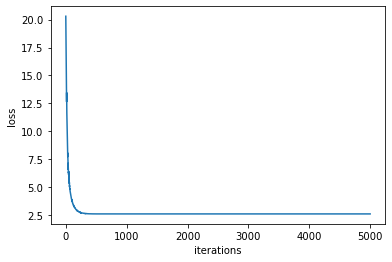

In [21]:
optimizer = optax.adam(learning_rate=0.1)
epochs = 5000
seed = jax.random.PRNGKey(10)
params = model.init(seed)

loss_fn = partial(model.loss_fn,batch = dataset,  data_size = len(dataset), aux = {}, n_samples = 10)
model_params = train(loss_fn, params, optimizer = optimizer, n_epochs = epochs, seed = jax.random.PRNGKey(100),return_args = ["losses"])

plt.plot(model_params["losses"])
plt.xlabel("iterations")
plt.ylabel("loss")

## Plotting results

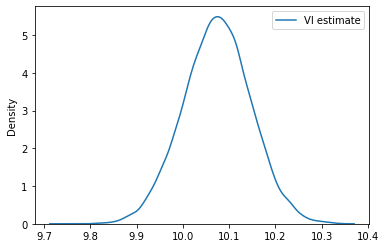

In [22]:
posterior = model.apply(model_params["params"])
samples = posterior.sample(seed = jax.random.PRNGKey(10), sample_shape=(10000,))
sns.kdeplot(samples["theta"],label = "VI estimate")
plt.legend()

In [23]:
with open("../results/weibull_poisson/results_data/weibull_Ajax",'wb') as f:
    pickle.dump(posterior, f,protocol = 1)